## Benchmark 6 revisit: linear models with structured bootstrap resampling
OK, so first round of linear model submissions to the public leaderboard produced some concerning results. TLDR: control resampling distribution seems to predict public leaderboard result well, linear models do not. Bootstrapping result look as if both Seigel and Theil-Sen regression will beat naive control with high probability, but both receive low scores that are extremely unlikely given their observed bootstrapped score distributions. What's going on? Let's try and find out - first thing is to check every step by manually inspecting output for sanity.

Note: this is version 2 of this notebook, version 1 was preserved in the state which produced the suspect results under investigation for reference.

While we are at it, let's start a major refactor here and move away from using notebooks for our main data generating logic and functions and instead use them just for plotting and discussion.

1. [Abbreviations & definitions](#abbrevations_definitions)
2. [Results](#results)

<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count
+ OLS: ordinary least squares
+ Model order: number of past timepoints used as input data for model training
+ Origin (forecast origin): last known point in the input data
+ Horizon (forecast horizon): number of future data points predicted by the model
+ SMAPE: Symmetric mean absolute percentage error

In [1]:
import sys
sys.path.append('..')
import config as conf
import functions.parallelization_functions as parallel_funcs

paths = conf.DataFilePaths()
params = conf.LinearModelsBootstrappingParameters()

import statistics
import multiprocessing as mp
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statistics import NormalDist

<a name="results"></a>
### 2. Results

In [2]:
# Load and inspect results - each row is an individual datapoint from one of the conditions/samples
input_file = f'{paths.BOOTSTRAPPING_RESULTS_PATH}/{params.output_file_root_name}.parquet'
data_df = pd.read_parquet(input_file)
data_df.head()

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
0,0,control,4,0.007134,0.007010,1.197231,1.180416,"[1.1913542, 1.2168832, 1.2140466, 1.1972311]","[0.0056730999999998755, 0.025529000000000135, ...",1.18872
1,0,OLS,4,0.016566,0.010621,1.208577,1.176161,"[1.1913542, 1.2168832, 1.2140466, 1.1972311]","[0.0056730999999998755, 0.025529000000000135, ...",1.18872
2,0,TS,4,0.013222,0.014331,1.204542,1.171805,"[1.1913542, 1.2168832, 1.2140466, 1.1972311]","[0.0056730999999998755, 0.025529000000000135, ...",1.18872
3,0,Seigel,4,0.010597,0.018923,1.201384,1.166437,"[1.1913542, 1.2168832, 1.2140466, 1.1972311]","[0.0056730999999998755, 0.025529000000000135, ...",1.18872
4,0,Ridge,4,0.016056,0.007232,1.207961,1.180154,"[1.1913542, 1.2168832, 1.2140466, 1.1972311]","[0.0056730999999998755, 0.025529000000000135, ...",1.18872


In [3]:
# Calculate the final SMAPE score for each sample in each condition
sample_smape_scores_df = data_df.groupby(['sample', 'model_type', 'model_order'])[['SMAPE_values', 'detrended_SMAPE_values']].mean().mul(100)

# Rename columns to reflect the change from SMAPE values for a single prediction to
# SMAPE scores within a sample
sample_smape_scores_df.rename(inplace=True, columns={'SMAPE_values': 'SMAPE_score', 'detrended_SMAPE_values': 'detrended_SMAPE_score'})

# Clean up index and inspect. Now each sample in all of the conditions is represented by a single row
# with two SMAPE scores calculated from all of the datapoints in that condition and sample. One from
# the fit and forecast on the raw data and the other from the fit and forecast on the difference
# detrended data
sample_smape_scores_df.reset_index(inplace=True, drop=False)
sample_smape_scores_df.head()

,sample,model_type,model_order,SMAPE_score,detrended_SMAPE_score
0,0,OLS,4,3.429214,3.966415
1,0,OLS,8,3.482866,2.968860
2,0,OLS,16,5.687728,2.977525
3,0,OLS,32,6.127524,2.600077
4,0,Ridge,4,3.204490,3.703140


OK, let's take a look! Going to use a boxplot to look at the distribution of sample SMAPE scores across the different models and model orders. We also have fits to the raw and detrended data to look at. Keep in mind that the detrended fit was used to generate a raw MBD value for scoring purposes, so the underlying scale of the raw and detrended data panels are the same.

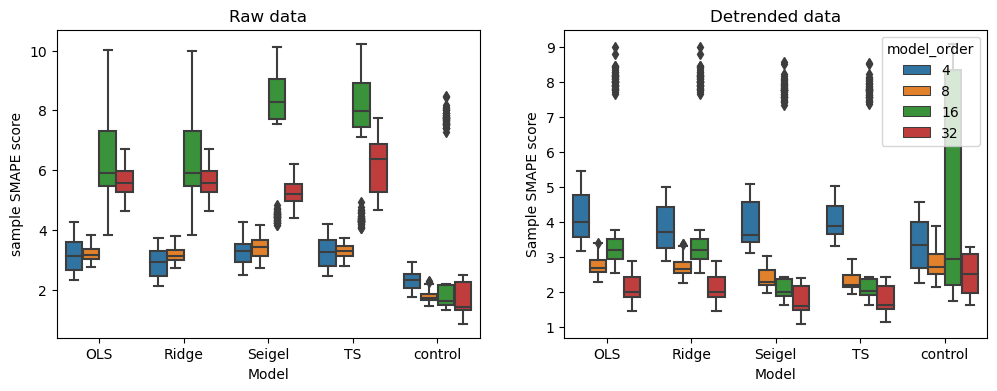

In [4]:
fig, ax = plt.subplots(1, 2,figsize=(12,4))

sns.boxplot(
    data=sample_smape_scores_df, 
    x='model_type',
    y='SMAPE_score',
    hue='model_order',
    ax=ax[0]
)

ax[0].set(
    xlabel='Model', 
    ylabel='sample SMAPE score', 
    title='Raw data'
)
        # Collect detrended model forecast
ax[0].get_legend().remove()

sns.boxplot(
    data=sample_smape_scores_df, 
    x='model_type',
    y='detrended_SMAPE_score',
    hue='model_order',
    ax=ax[1]
)

ax[1].set(
    xlabel='Model', 
    ylabel='Sample SMAPE score', 
    title='Detrended data'
)

plt.show()

Now, let's compare another way by plotting individual SMAPE values for all the datapoints in control vs regression.


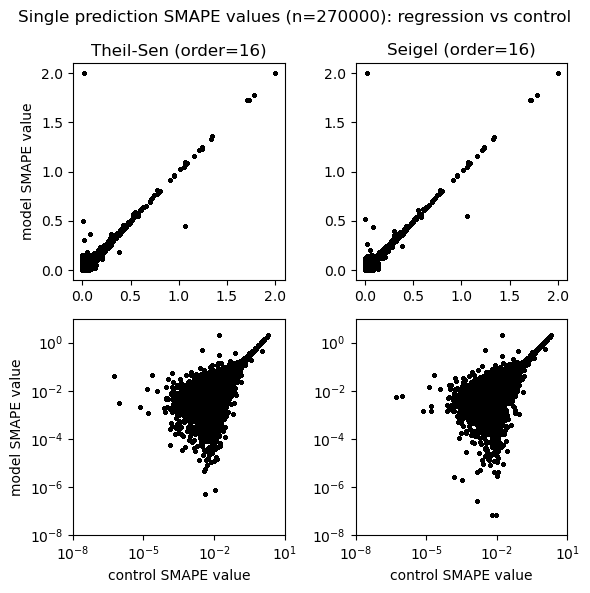

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax[0,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'],
    color='black',
    s=4
)

ax[0,0].set_ylabel('model SMAPE value')
ax[0,0].set_title('Theil-Sen (order=16)')

ax[0,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'],
    color='black',
    s=4
)

ax[0,1].set_title('Seigel (order=16)')

ax[1,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'],
    color='black',
    s=4
)

ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('control SMAPE value')
ax[1,0].set_ylabel('model SMAPE value')
ax[1,0].set_xlim([10**-8,10])
ax[1,0].set_ylim([10**-8,10])

ax[1,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'],
    color='black',
    s=4
)

ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('control SMAPE value')
ax[1,1].set_xlim([10**-8,10])
ax[1,1].set_ylim([10**-8,10])

n = len(data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'])
plt.suptitle(f'Single prediction SMAPE values (n={n}): regression vs control')
plt.tight_layout()

Let's take a closer look at our winner(s).

In [6]:
# Aggregate scores again, this time averaging all of the samples in each condition so we have one datapoint for each model and order
mean_sample_smape_score_df = sample_smape_scores_df.groupby(['model_type', 'model_order'])[['SMAPE_score', 'detrended_SMAPE_score']].mean()

# Rename columns to reflect new value
mean_sample_smape_score_df.rename(inplace=True, columns={'SMAPE_score': 'mean_SMAPE_score', 'detrended_SMAPE_score': 'mean_detrended_SMAPE_score'})

# Clean up and inspect
mean_sample_smape_score_df.reset_index(inplace=True, drop=False)
mean_sample_smape_score_df.head()

,model_type,model_order,mean_SMAPE_score,mean_detrended_SMAPE_score
0,OLS,4,3.145217,4.158557
1,OLS,8,3.194741,2.738548
2,OLS,16,6.417398,4.172909
3,OLS,32,5.622215,2.080083
4,Ridge,4,2.876339,3.835929


In [7]:
# Get top 10 models by mean detrended SMAPE score
detrended_top_10 = mean_sample_smape_score_df.sort_values(by=['mean_detrended_SMAPE_score']).head(10)

# Get winner type and order
winning_model_type = detrended_top_10['model_type'].to_list()[0]
winning_model_order = detrended_top_10['model_order'].to_list()[0]

# Get raw data for winner
winner = data_df[(data_df['model_type'] == winning_model_type) & (data_df['model_order'] == winning_model_order)]

# Get raw data for sample matched control
control = data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == winning_model_order)]

# Inspect
control.head(3)

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
22500,0,control,32,0.042553,0.086956,1.669086,1.596517,"[1.6087517, 1.6087517, 1.6372796, 1.952141, 2....","[-0.3217502000000001, 0.0, 0.02852790000000005...",1.741655
22505,0,control,32,0.007722,0.007663,1.205044,1.223727,"[1.0450745, 1.0541621, 1.0619793, 1.0345143, 1...","[0.036350399999999894, 0.009087600000000196, 0...",1.214386
22510,0,control,32,0.016584,0.006557,3.064781,3.136532,"[1.4759005, 1.4139746, 1.4567621, 1.4464304, 1...","[0.11353080000000015, -0.06192590000000009, 0....",3.116031


In [8]:
winner.head(3)

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
22503,0,Seigel,32,0.280631,0.042553,2.310191,1.669086,"[1.6087517, 1.6087517, 1.6372796, 1.952141, 2....","[-0.3217502000000001, 0.0, 0.02852790000000005...",1.741655
22508,0,Seigel,32,0.037810,0.005466,1.169322,1.207765,"[1.0450745, 1.0541621, 1.0619793, 1.0345143, 1...","[0.036350399999999894, 0.009087600000000196, 0...",1.214386
22513,0,Seigel,32,0.015627,0.006964,3.067713,3.137806,"[1.4759005, 1.4139746, 1.4567621, 1.4464304, 1...","[0.11353080000000015, -0.06192590000000009, 0....",3.116031


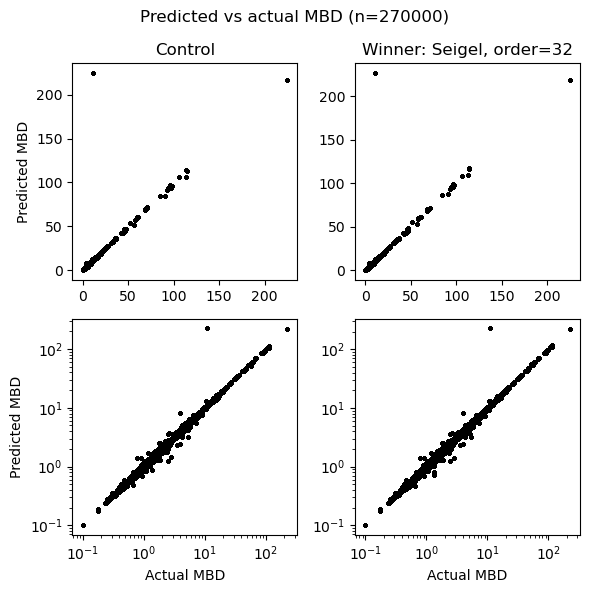

In [9]:
# Plot true vs predicted values
fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax[0,0].scatter(
    control['MBD_actual'],
    control['MBD_predictions'],
    color='black',
    s=4
)

ax[0,0].set_ylabel('Predicted MBD')
ax[0,0].set_title('Control')

ax[0,1].scatter(
    winner['MBD_actual'],
    winner['detrended_MBD_predictions'],
    color='black',
    s=4
)

ax[0,1].set_title(f'Winner: {winning_model_type}, order={winning_model_order}')

ax[1,0].scatter(
    control['MBD_actual'],
    control['MBD_predictions'],
    color='black',
    s=4
)

ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')

ax[1,0].set_xlabel('Actual MBD')
ax[1,0].set_ylabel('Predicted MBD')

ax[1,1].scatter(
    winner['MBD_actual'],
    winner['detrended_MBD_predictions'],
    color='black',
    s=4
)

ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')

ax[1,1].set_xlabel('Actual MBD')

n = len(winner['MBD_actual'])
plt.suptitle(f'Predicted vs actual MBD (n={n})')
plt.tight_layout()

In [10]:
control_sample_smape_scores = sample_smape_scores_df[(sample_smape_scores_df['model_type'] == 'control') & (sample_smape_scores_df['model_order'] == winning_model_order)]
control_sample_smape_scores['SMAPE_score'].describe()

count    180.000000
mean       1.561848
std        0.521477
min        0.855174
25%        1.317946
50%        1.429338
75%        2.244805
max        2.500029
Name: SMAPE_score, dtype: float64

In [11]:
winner_sample_smape_scores = sample_smape_scores_df[(sample_smape_scores_df['model_type'] == winning_model_type) & (sample_smape_scores_df['model_order'] == winning_model_order)]
winner_sample_smape_scores['detrended_SMAPE_score'].describe()

count    180.000000
mean       1.664899
std        0.401164
min        1.089781
25%        1.495770
50%        1.595519
75%        2.172901
max        2.394467
Name: detrended_SMAPE_score, dtype: float64

In [12]:
t_test = stats.ttest_ind(winner_sample_smape_scores['detrended_SMAPE_score'], control_sample_smape_scores['SMAPE_score'])
print(f't-test p-value (H0: control mean = regression mean): {t_test[1]:.3e}')

t-test p-value (H0: control mean = regression mean): 3.630e-02


In [13]:

cm = sms.CompareMeans(sms.DescrStatsW(winner_sample_smape_scores['detrended_SMAPE_score']), sms.DescrStatsW(control_sample_smape_scores['SMAPE_score']))
ci = cm.tconfint_diff(usevar='unequal')
print(f'95% C.I. around difference in means: {ci[0]:.4f}, {ci[1]:.3f}')

95% C.I. around difference in means: 0.0066, 0.200


In [14]:
smape_mean = statistics.mean(winner_sample_smape_scores['detrended_SMAPE_score'])
smape_std = statistics.pstdev(winner_sample_smape_scores['detrended_SMAPE_score'])

print(f'Mean: {smape_mean:.3f}')
print(f'Standard deviation: {smape_std:.4f}')
print()

leaderboard_score_probability = NormalDist(mu=smape_mean, sigma=smape_std).cdf(1.0936)
print(f'Probability of SMAPE <= 1.0936: {leaderboard_score_probability:.3f}')
print(f'Probability of SMAPE > 1.0936: {1 - leaderboard_score_probability:.3f}')

Mean: 1.665
Standard deviation: 0.4000

Probability of SMAPE <= 1.0936: 0.077
Probability of SMAPE > 1.0936: 0.923


OK, unfortunately - this is more like the answer we should be getting.The winning model performs worse than the control on average, but not by much.  The control and winning distributions are definitely different. The difference, though small, is highly statistically significant because of the large sample sizes involved.

Let's check the probabilities of the observed leaderboard results before we move on to try and improve the result.

In [15]:
smape_mean = statistics.mean(winner_sample_smape_scores['detrended_SMAPE_score'])
smape_std = statistics.pstdev(winner_sample_smape_scores['detrended_SMAPE_score'])

print(f'Winner mean: {smape_mean:.3f}')
print(f'Winner standard deviation: {smape_std:.4f}')
print()

leaderboard_score_probability = NormalDist(mu=smape_mean, sigma=smape_std).cdf(1.2027)
print(f'Probability of model SMAPE <= 1.2027: {leaderboard_score_probability:.3f}')
print(f'Probability of model SMAPE > 1.2027: {1 - leaderboard_score_probability:.3f}')

Winner mean: 1.665
Winner standard deviation: 0.4000

Probability of model SMAPE <= 1.2027: 0.124
Probability of model SMAPE > 1.2027: 0.876


In [16]:
smape_mean = statistics.mean(control_sample_smape_scores['SMAPE_score'])
smape_std = statistics.pstdev(control_sample_smape_scores['SMAPE_score'])

print(f'Control mean: {smape_mean:.3f}')
print(f'Control standard deviation: {smape_std:.4f}')
print()

leaderboard_score_probability = NormalDist(mu=smape_mean, sigma=smape_std).cdf(1.0936)
print(f'Probability of control SMAPE <= 1.0936: {leaderboard_score_probability:.3f}')
print(f'Probability of control SMAPE > 1.0936: {1 - leaderboard_score_probability:.3f}')

Control mean: 1.562
Control standard deviation: 0.5200

Probability of control SMAPE <= 1.0936: 0.184
Probability of control SMAPE > 1.0936: 0.816


Interesting - both observed scores split the sampling distribution at approximately the same place. A pretty good showing on the leaderboard for both ~3 in 20 chance shot to do as well or better than observed for both.

Problem is, we are still loosing. On the bright side - we now can get a much better handle on the expected leaderboard results looking at our internal bootstrapping benchmark.